# Modified file

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  4 08:30:08 2024

@author: LMEJIACRUZ
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import next_fast_len


#%% Foot-Step Wavelet Function
def foot_step_wavelet(t, central_frequency=2.14):
    """
    Constructs the Foot-Step wavelet, a custom time-domain wavelet designed for step-event analysis.
    The wavelet captures both sharp impacts and oscillatory dynamics using dual-frequency components 
    modulated by a Gaussian window.

    Parameters:
    ----------
    t : numpy.ndarray
        Time array representing the temporal domain.
    central_frequency : float, optional
        The primary central frequency of the wavelet (default is 2.14 Hz).

    Returns:
    -------
    signal : numpy.ndarray
        The wavelet function evaluated over the input time array.

    Notes:
    -----
    - The wavelet consists of two cosine components: one with the central frequency and another 
      with a secondary frequency to capture subtle dynamics.
    - A Gaussian window is applied to ensure time localization.
    - The wavelet is normalized for unit energy and adjusted to have zero mean.

    Example:
    --------
    >>> import numpy as np
    >>> t = np.linspace(-2, 2, 1000)  # Generate a time vector
    >>> wavelet = foot_step_wavelet(t, central_frequency=2.14)
    >>> print(wavelet)
    """
    A = 1
    phase = 1.27*np.pi # Adjust phase to shift the alignment of peaks 1.27pi
    
    
    # # # Option: Add a second, smaller frequency component to affect secondary peaks
    secondary_amplitude = -1.25  # Experiment with smaller amplitude for secondary frequency
    #secondary_amplitude = 1.25  # It is positive in the paper.
    secondary_freq = 1.43  # A different frequency to modulate the shape of the wavelet


    ## MJB: foot_step_wavelet_devlopenet has a t/scale=5.0, not sure why
    #t = t/5.0 
    # MJB: the signal line is totaly different, done in 2 parts but looks the same
    # Main cosine wave
    signal = A * np.cos(2 * np.pi * central_frequency * t + phase)
    signal += secondary_amplitude * np.cos(2 * np.pi * secondary_freq * t + phase)    
    #signal = A * np.cos(2 * np.pi * central_frequency * t + phase) + \
    #         secondary_amplitude * np.cos(2 * np.pi * secondary_freq * t + phase)

    
    # Gaussian window decay
    window =0.7 #0.8  # Experiment with a slightly larger window for slower decay
    signal *= np.exp(-t**2 / (2 * window**2))
    
    # Subtract the mean to ensure zero mean
    signal -= np.mean(signal)
    
    #MJB: We don't want to norm here. If there are no steps we want it quiet
    # We norm to the full dataset.
    signal /= np.sqrt(np.sum(signal**2)) # Normalize to unit energy
    signal /= np.max(np.abs(signal)) # Normalize to max amplitude of 1
    
    return signal


def foot_step_wavelet_complex(t, central_frequency=2.14):
    """
    Complex Foot-Step wavelet: sum of two complex exponentials under a Gaussian window.
    Returns complex-valued array (analytic-like).
    """
    A = 1.0
    phase = 1.27 * np.pi
    secondary_amplitude = -1.25
    secondary_freq = 1.43

    # Complex exponentials (cos + i sin)
    signal = A * np.exp(1j * (2*np.pi * central_frequency * t + phase))
    signal += secondary_amplitude * np.exp(1j * (2*np.pi * secondary_freq * t + phase))

    # Gaussian window
    window = 0.7
    signal *= np.exp(-t**2 / (2 * window**2))

    # Zero mean (complex)
    signal -= np.mean(signal)

    # Normalize to unit energy
    signal /= np.sqrt(np.sum(np.abs(signal)**2))

    return signal



# Create a class for your custom wavelet, without subclassing pywt.ContinuousWavelet
class FootStepWavelet:
    """
     A custom wavelet class designed to capture the unique characteristics of footstep-induced vibrations.
     This implementation was adapted from the PyWavelets library's approach to handling continuous wavelets
     and modified to support a dual-frequency custom wavelet structure.
    
     Parameters:
     ----------
     central_frequency : float, optional
         The primary central frequency of the wavelet (default is 2 Hz).
    
     Attributes:
     ----------
     central_frequency : float
         The primary frequency component of the wavelet, used for scaling and frequency mapping.
     _is_complex : bool
         Internal flag indicating whether the wavelet is complex-valued (False by default).
     support : list
         The time range over which the wavelet is defined, typically symmetrical around zero.
    
     Methods:
     -------
     wavefun(length=None):
         Returns the wavelet function values and the corresponding time array.
         - `length`: Number of points in the time vector (default is 1000).
     
     complex_cwt:
         A property indicating whether the wavelet is complex-valued (False for FootStepWavelet).
    
     Notes:
     -----
     - This custom wavelet class was designed specifically for walking-induced vibrations, 
       integrating dual-frequency components to capture both sharp impacts and slower oscillatory dynamics.
     - While not subclassing `pywt.ContinuousWavelet`, this class retains compatibility with 
       PyWavelets-based workflows for use in Continuous Wavelet Transform (CWT) calculations.
     - The `wavefun` method generates the time-domain representation of the wavelet, using the 
       `foot_step_wavelet` function to create the wavelet's shape.
    
     Example:
     --------
     >>> footstep_wavelet = FootStepWavelet(central_frequency=2.14)
     >>> wavelet_values, time = footstep_wavelet.wavefun(length=500)
     >>> print("Wavelet values:", wavelet_values)
     >>> print("Time vector:", time)
     """
    def __init__(self, central_frequency=2.0, complex_cwt=True):
        self.central_frequency = central_frequency
        self._is_complex = bool(complex_cwt)  # Internal flag to indicate if the wavelet is complex
        self.support = [-8,8]
    # Method to return the wavelet function and the time array
    def wavefun(self, length=None):
        if length is None:
            length = 1000  # Default length if none provided
        t = np.linspace(self.support[0], self.support[1], length)
        if self._is_complex:
            w = foot_step_wavelet_complex(t, central_frequency=self.central_frequency)
        else:
            # original real-valued version
            w = foot_step_wavelet(t, central_frequency=self.central_frequency)
        return w, t

    @property
    def complex_cwt(self):
        return self._is_complex


def step_integrate_wavelet(wavelet, precision=8):
    """
    Integrates a continuous wavelet over time for use in Continuous Wavelet Transform (CWT) calculations.

    Parameters:
    ----------
    wavelet : pywt.ContinuousWavelet
        A continuous wavelet object (e.g., 'morl', 'mexh', or custom wavelets like the Foot-Step wavelet).
    precision : int, optional
        The precision of the integration. The time vector will contain 2**precision points.
        Higher precision results in finer integration.

    Returns:
    -------
    int_psi : numpy.ndarray
        The integrated wavelet values over the specified time range.
    t : numpy.ndarray
        The time vector corresponding to the integrated wavelet.

    Notes:
    -----
    - This function was adapted from PyWavelets' wavelet integration methods to support custom
      wavelets, such as the Foot-Step wavelet, while retaining compatibility with standard 
      wavelets like Morlet or Mexican Hat.
    - The integration is performed over the wavelet's support range, and the resulting values
      are normalized to maintain energy consistency.

    Example:
    --------
    >>> wavelet = FootStepWavelet()
    >>> int_psi, t = step_integrate_wavelet(wavelet, precision=10)
    >>> print("Integrated wavelet:", int_psi)
    >>> print("Time vector:", t)
    """
    
    # Define a time vector based on the given precision
    N = 2 ** precision
    t = np.linspace(wavelet.support[0], wavelet.support[1], N)
    
    # Get the wavelet function values for the time vector
    psi, _ = wavelet.wavefun(length=N)
    
    # Normalize and integrate the wavelet values over the time vector
    int_psi = np.sqrt(np.abs(np.trapz(psi**2, t))) * psi
    
    return int_psi, t

def step_scale2frequency(wavelet, scale):
    """
    Converts a scale to its corresponding frequency for a given wavelet.

    Parameters:
    ----------
    wavelet : object
        The wavelet object containing a `central_frequency` attribute.
    scale : float or array_like
        The scale value(s) to convert to frequency.

    Returns:
    -------
    frequency : float or ndarray
        The frequency corresponding to the input scale(s).

    Notes:
    -----
    - This function was adapted from the scale-to-frequency conversion method in the 
      PyWavelets library to work seamlessly with custom wavelets, such as the Foot-Step wavelet.
    - The conversion uses the formula: `frequency = central_frequency / scale`, where
      `central_frequency` is a characteristic property of the wavelet.

    Example:
    --------
    >>> wavelet = FootStepWavelet(central_frequency=2.14)
    >>> scale = [1, 2, 3]
    >>> frequencies = step_scale2frequency(wavelet, scale)
    >>> print(frequencies)
    """
   
    # Get the predefined central frequency of the wavelet
    central_frequency = wavelet.central_frequency
    
    # Convert the scale(s) to frequency using the formula: frequency = central_frequency / scale
    frequency = central_frequency / np.asarray(scale)
    
    return frequency


# Instantiate your custom wavelet
#footstep_wavelet = FootStepWavelet(2.14)
#plt.plot(footstep_wavelet.wavefun()[1],footstep_wavelet.wavefun()[0])
#plt.show()


#%%
#def foot_step_cwt(data, scales, sampling_period=1., method='conv', axis=-1):
def foot_step_cwt(data, scales, sampling_period=1., f_0=2.14, method='conv', axis=-1): #MJB: need the f0 as an argument
    """
    Compute the Continuous Wavelet Transform (CWT) using the custom Foot-Step wavelet, 
    tailored for walking-induced vibrations. This implementation adapts and extends 
    the wavelet transform methodology from PyWavelets, with additional features 
    for handling step-related events.

    Parameters:
    ----------
    data : array-like
        Input signal to be transformed.
    scales : array-like
        Array of scales at which to compute the wavelet transform.
    sampling_period : float, optional
        The sampling period of the signal, by default 1.
    f_0 : Centeral freqquency
    method : str, optional
        Convolution method to use ('conv' or 'fft'). Default is 'conv'.
    axis : int, optional
        Axis of the input array along which to compute the transform. Default is -1.

    Returns:
    -------
    out : ndarray
        Wavelet coefficients, with shape `(len(scales), ...)` depending on the input signal.
    frequencies : ndarray
        Frequencies corresponding to the scales, adjusted for the sampling period.

    Notes:
    -----
    - This function is modified from the Continuous Wavelet Transform implementation 
      in the PyWavelets library to incorporate the Foot-Step wavelet. Special thanks 
      to the PyWavelets team for their foundational work.
    - The Foot-Step wavelet is initialized with a central frequency of 2.14 Hz, 
      and the integration is performed using a Gaussian envelope.
    - This method evaluates wavelet coefficients while ensuring zero-mean and 
      scale normalization for robust step-event detection.

    Example:
    --------
    >>> data = [your_signal]
    >>> scales = [1, 2, 3]
    >>> coefficients, frequencies = foot_step_cwt(data, scales)
    >>> print(coefficients.shape, frequencies)
    """
    from math import ceil, floor
    import numpy as np
    import scipy
    from pywt._extensions._pywt import _check_dtype
    from numpy import AxisError
    fftmodule = scipy.fft
    
    wavelet = FootStepWavelet(central_frequency=f_0) # MJB
    #wavelet = FootStepWavelet(central_frequency=2.14)
    
    
    # wavelet = 'morl'
    dt = _check_dtype(data)

    data = np.asarray(data, dtype=dt)
    dt_cplx = np.result_type(dt, np.complex64)
    
   
    scales = np.atleast_1d(scales)
    if np.any(scales <= 0):
        raise ValueError("`scales` must only include positive values")

    if not np.isscalar(axis):
        raise AxisError("axis must be a scalar.")

    # output complex coefficients if wavelet is complex
    # else output real coefficients
    dt_out = dt_cplx if wavelet.complex_cwt else dt
    out = np.empty((np.size(scales),) + data.shape, dtype=dt_out)
    precision = 10
    int_psi, x = step_integrate_wavelet(wavelet, precision=precision)
    int_psi = np.conj(int_psi) if wavelet.complex_cwt else int_psi

    # convert int_psi, x to the same precision as the data
    dt_psi = dt_cplx if int_psi.dtype.kind == 'c' else dt
    int_psi = np.asarray(int_psi, dtype=dt_psi)
    x = np.asarray(x, dtype=data.real.dtype)

    if method == 'fft':
        size_scale0 = -1
        fft_data = None
    elif method != "conv":
        raise ValueError("method must be 'conv' or 'fft'")

    if data.ndim > 1:
        # move axis to be transformed last (so it is contiguous)
        data = data.swapaxes(-1, axis)

        # reshape to (n_batch, data.shape[-1])
        data_shape_pre = data.shape
        data = data.reshape((-1, data.shape[-1]))

    for i, scale in enumerate(scales):
        step = x[1] - x[0]
        j = np.arange(scale * (x[-1] - x[0]) + 1) / (scale * step)
        j = j.astype(int)  # floor
        if j[-1] >= int_psi.size:
            j = np.extract(j < int_psi.size, j)
        int_psi_scale = int_psi[j][::-1]

        if method == 'conv':
            if data.ndim == 1:
                conv = np.convolve(data, int_psi_scale)
            else:
                # batch convolution via loop
                conv_shape = list(data.shape)
                conv_shape[-1] += int_psi_scale.size - 1
                conv_shape = tuple(conv_shape)
                conv = np.empty(conv_shape, dtype=dt_out)
                for n in range(data.shape[0]):
                    conv[n, :] = np.convolve(data[n], int_psi_scale)
        else:
            # The padding is selected for:
            # - optimal FFT complexity
            # - to be larger than the two signals length to avoid circular
            #   convolution
            size_scale = next_fast_len(
                data.shape[-1] + int_psi_scale.size - 1
            )
            if size_scale != size_scale0:
                # Must recompute fft_data when the padding size changes.
                fft_data = fftmodule.fft(data, size_scale, axis=-1)
            size_scale0 = size_scale
            fft_wav = fftmodule.fft(int_psi_scale, size_scale, axis=-1)
            conv = fftmodule.ifft(fft_wav * fft_data, axis=-1)
            conv = conv[..., :data.shape[-1] + int_psi_scale.size - 1]

        coef = - np.sqrt(scale) * np.diff(conv, axis=-1)
        if out.dtype.kind != 'c':
            coef = coef.real
        # transform axis is always -1 due to the data reshape above
        d = (coef.shape[-1] - data.shape[-1]) / 2.
        if d > 0:
            coef = coef[..., floor(d):-ceil(d)]
        elif d < 0:
            raise ValueError(
                f"Selected scale of {scale} too small.")
        if data.ndim > 1:
            # restore original data shape and axis position
            coef = coef.reshape(data_shape_pre)
            coef = coef.swapaxes(axis, -1)
        out[i, ...] = coef
            
    frequencies = step_scale2frequency(wavelet, scale=scales)
    
    if np.isscalar(frequencies):
        frequencies = np.array([frequencies])
    frequencies /= sampling_period
  
    return out, frequencies


# Helper function to compute scales and corresponding frequencies
def get_scales(wavelet, min_freq, max_freq, fs, nscales=300):
    """
    Computes the scales and their corresponding frequencies for a given wavelet, based on 
    the specified frequency range and sampling frequency.
    
    Parameters:
    ----------
    wavelet : str or custom wavelet object
        The name of a standard wavelet (e.g., 'morl', 'mexh') or a custom wavelet object
        (e.g., 'fstep_wavelet').
    min_freq : float
        The minimum frequency (in Hz) of the target range.
    max_freq : float
        The maximum frequency (in Hz) of the target range.
    fs : float
        The sampling frequency of the signal (in Hz).
    nscales : int, optional
        The number of scales to generate between the min_scale and max_scale. Default is 300.
    
    Returns:
    -------
    scales : numpy.ndarray
        The scales corresponding to the specified frequency range.
    frequencies : numpy.ndarray
        The frequencies (in Hz) corresponding to the scales.
    
    Notes:
    -----
    - The wavelet's central frequency is used to establish the relationship between scales 
      and frequencies.
    - Custom wavelets, such as 'fstep_wavelet', must provide a `central_frequency` property 
      to compute the scales accurately.
    
    Example:
    --------
    >>> scales, frequencies = get_scales('morl', 0.5, 2.5, fs=1000)
    >>> print(scales)
    >>> print(frequencies)
    """
    import pywt
        
    if wavelet=='fstep_wavelet':
        wavelet = FootStepWavelet()    
        center_frequency =wavelet.central_frequency
    else:
        center_frequency = pywt.central_frequency(wavelet)
        
    
    min_scale = center_frequency * fs / max_freq
    max_scale = center_frequency * fs / min_freq
    scales = np.linspace(min_scale, max_scale, nscales)
    
    frequencies = center_frequency / (scales * (1 / fs))  # Calculate corresponding frequencies
    return scales, frequencies



#%% 
#-------------------------------------------------------------------------------
# --------------------------Example usage#%% ----------------------------------
#-------------------------------------------------------------------------------
def fstWvt_ex(): #MJB, made function so I can import foot_step_wavelet.py
    import os
    import h5py

    print(f"Load Data")
    #data_folder = '../dataOnFastDrive' # MJB, Renamed for data location
    data_folder = '../Wavelet/Single Steps Data' # MJB, Renamed for data location
    with h5py.File(os.path.join(data_folder, 'one_step_plate_test.hdf5'), 'r') as hdf:
        filePerams = hdf['experiment/general_parameters'][:] #MJB
        dataCapRate_hz =filePerams[0]['value']#.decode('utf-8') # Data cap rate is the first entery (number 0)
        print(f"Data Cap Rate: {dataCapRate_hz}")
    
        experiment_group = hdf['/experiment']

        dataset = experiment_group['data']
        print(f"Data size: {dataset.shape}, {dataset.shape[0]} trials") #MJB
        all_data =[]
        for i in range(dataset.shape[0]):
            data_i = []
            for j in range(dataset.shape[1]):
                data_i.append(dataset[i][j])
            all_data.append(data_i)
    

    print(f"Prep Wavelet")
    # Access the Steps Data
    trial_i , sensor_i = 0, 0
    signal =  all_data[trial_i][sensor_i]

    fs = 2048
    record_length = int(len(signal)/fs)
    time = np.linspace(0, record_length,len(signal)) # Time vector for 10 seconds of data

    nscales = 300
    scales_hstep, frequencies_hstep= get_scales(wavelet= 'fstep_wavelet', 
                                            min_freq=0.5, max_freq=50, fs=fs, 
                                            nscales=nscales)
    #print(frequencies_hstep)
    print(f"Calculate CWT")
    coefficients_hstep, frequencies_hstep = foot_step_cwt(signal, scales_hstep, 
                                                      sampling_period=1/(fs))


    print(f"Plot Data")
    fig, ax = plt.subplots(1,1, figsize=(15, 10), sharey=True, sharex=True)
    cwt_image_hstep = ax.imshow(np.abs(coefficients_hstep), aspect='auto', 
                            cmap='viridis',extent=[time[0], time[-1], 
                                                   frequencies_hstep[0], 
                                                   frequencies_hstep[-1]])
    ax.set_title(' Foot-Step CWT Scalogram')
    ax.set_ylabel('Frequency [Hz]')
    fig.colorbar(cwt_image_hstep, ax=ax, label='Coefficients')
    plt.show()

---
# Plot of original Real function

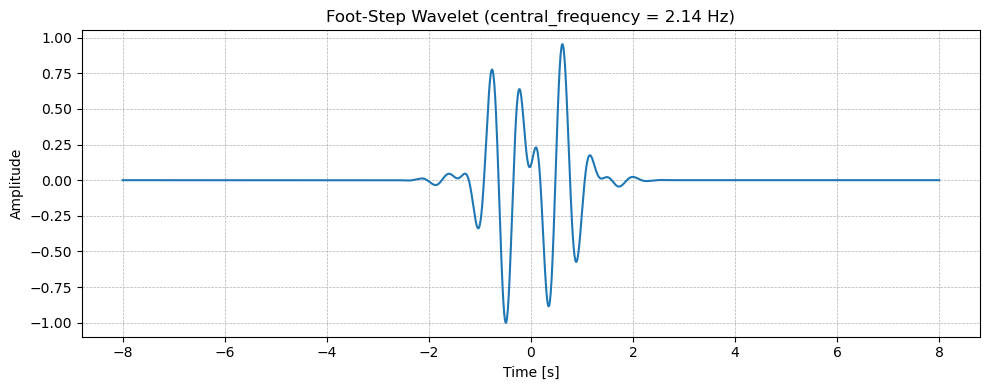

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Foot-Step Wavelet Function
def foot_step_wavelet(t, central_frequency=2.14):
    A = 1
    phase = 1.27*np.pi  # phase shift
    
    # Secondary component
    secondary_amplitude = -1.25
    secondary_freq = 1.43

    # Main + secondary cosine components
    signal = A * np.cos(2 * np.pi * central_frequency * t + phase)
    signal += secondary_amplitude * np.cos(2 * np.pi * secondary_freq * t + phase)    

    # Gaussian window
    window = 0.7
    signal *= np.exp(-t**2 / (2 * window**2))
    
    # Zero mean and normalize
    signal -= np.mean(signal)
    signal /= np.sqrt(np.sum(signal**2))
    signal /= np.max(np.abs(signal))
    
    return signal

# Time vector and wavelet values
t = np.linspace(-8, 8, 2000)  # from -8 to 8 seconds, 2000 points
y = foot_step_wavelet(t, central_frequency=2.14)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, y)
plt.title("Foot-Step Wavelet (central_frequency = 2.14 Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


---
# Plot of Complex function

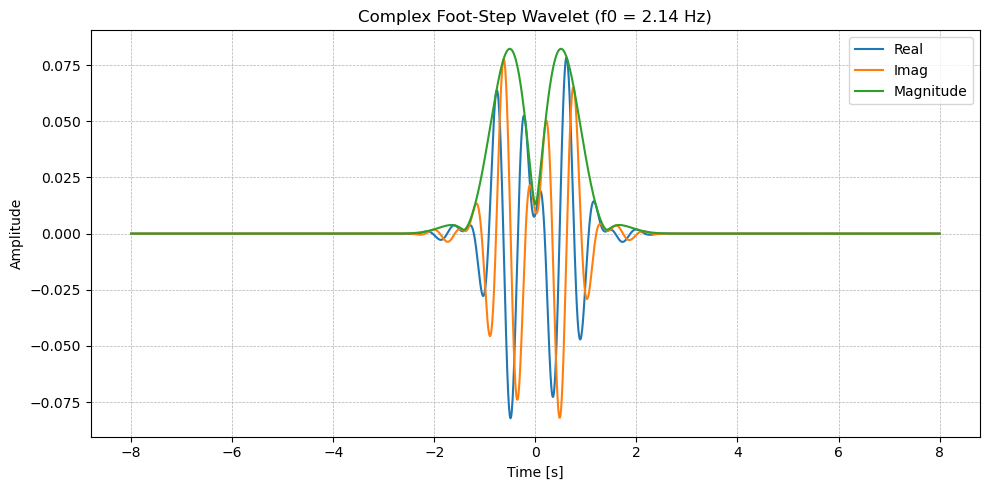

In [12]:
# Instantiate complex wavelet and plot parts
w = FootStepWavelet(central_frequency=2.14, complex_cwt=True)
psi, t = w.wavefun(length=2000)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(t, psi.real, label='Real')
plt.plot(t, psi.imag, label='Imag')
plt.plot(t, np.abs(psi), label='Magnitude')
plt.xlabel('Time [s]'); plt.ylabel('Amplitude')
plt.title('Complex Foot-Step Wavelet (f0 = 2.14 Hz)')
plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout(); plt.show()